# HDDA. Home Assignment 3

## 1. Derivation of EM for FA recognition
### Derive formulas of the model. Use latex notation to note them.

$$PDF(x) = \mathcal{N}(\mu, \ AA^T + \Psi)$$

The model for $y$:
$$p(y|\theta) = \int p(x|\theta)p(y|x, \theta)\mathrm{d}x = N(0, AA^T + \Psi)$$
Model parameters: $\theta = \{A, \Psi\}$

E step: For each data point $y_{n}$, compute the posterior distribution of hidden factors given the observed data: $q_{n}(x) = p(x|y_{n}, \theta) = p(x, y_{n}|\theta)/p(y_{n}|\theta)$

$$p(x, y_{n}) = p(x)p(y_{n}|x)$$
$$= (2\pi)^{-K/2}exp\{−1/2x^Tx\} |2π\Psi|^{−1/2} exp\{−1/2(y_{n} − Ax)^{T}\Psi^{-1}(y_{n} − Ax)\}$$
$$= c × \exp\{−1/2[x^{T}x + (y_{n} − Ax)\Psi^{−1}(y_{n} − Ax)]\}$$
$$= c’ × \exp\{−1/2[x^{T}(I + A^{T}\Psi^{−1}A)x − 2x^{T}A^{T}\Psi^{−1}y_{n}]\}$$
$$= c” × \exp\{−1/2[x^{T}Σ^{-1}x − 2x^{T}Σ^{-1}\mu + \mu^{T}Σ^{−1}\mu]\}$$

So $Σ = (I + A^{T}\Psi^{−1}A)^{−1} = I − \beta A$ and $\mu = ΣA^{T}\Psi^{−1}y_{n} = \beta y_{n}.$ Where $\beta = ΣA^{T}\Psi^{−1}.$ Note that $\mu$ is a linear function of $y_{n}$ and $Σ$ does not depend on $y_{n}.$

M step: Find the $\theta_{t+1}$ that maximises $F(q, \theta)$:
$$F(q, \theta) = \sum\int q_{n}(x)[\log p(x|\theta) + \log p(y_{n}|x, \theta) − \log q_{n}(x)] \mathrm{d}x$$
$$=\sum\int q_{n}(x)[\log p(x|\theta) + \log p(y_{n}|x, \theta)] \mathrm{d}x + c$$

$$\log p(x|\theta)+ \log p(y_{n}|x, \theta) = c −1/2x^{T}x −1/2\log |\Psi| − 1/2(y_{n} − Ax)^{T}\Psi^{−1}(y_{n} − Λx)$$
$$= c’ −1/2\log |\Psi| − 1/2[y_{n}^{T}\Psi^{−1}y_{n} − 2y_{n}^{T}\Psi^{−1}Ax + x^{T}A^{T}\Psi^{−1}Ax]$$
$$= c’ −1/2\log |\Psi| − 1/2[y_{n}^{T}\Psi^{−1}y_{n} − 2y_{n}^{T}\Psi^{−1}Ax + Tr [A^{T}\Psi^{−1}Axx^{T}]]$$
$$= c’ −1/2\log |\Psi| − 1/2[y_{n}^{T}\Psi^{−1}y_{n} − 2y_{n}^{T}\Psi^{−1}A\mu_{n} + Tr [A^{T}\Psi^{−1}A(\mu_{n}\mu_{n}^{T} + Σ)]]$$

$$F = c’ −N/2\log |\Psi| − 1/2\sum[y_{n}^{T}\Psi^{−1}y_{n} − 2y_{n}^{T}\Psi^{−1}A\mu_{n} + Tr [A^{T}\Psi^{−1}A(\mu_{n}\mu_{n}^{T} + Σ)]]$$

Taking derivatives w.r.t. $A$ and $\Psi^{−1}$, using $\frac{\partial_{Tr} [AB]}{\partial B}$  and $\frac{\partial \log |A|}{\partial A} = A^{-T}:$
$$\frac{\partial F}{\partial A} = \Psi^{−1}\sum y_{n}\mu_{n}^{T} − \Psi^{−1}A(NΣ + \sum \mu_{n}\mu_{n}^{T}) = 0$$
$$\hat{A} = (\sum y_{n}\mu_{n}^{T})(NΣ + \sum \mu_{n}\mu_{n}^{T})^{-1}$$
$$\frac{\partial F}{\partial \Psi^{-1}} = N/2\Psi − 1/2\sum [y_{n}y_{n}^{T} − A\mu_{n}y_{n}^{T} − y_{n}\mu_{n}^{T}A + A(\mu_{n}\mu_{n}^{T} + Σ)A^{T}]$$
$$\hat{\Psi} = 1/N\sum [y_{n}y_{n}^{T} − A\mu_{n}y_{n}^{T} − y_{n}\mu_{n}^{T}A + A(\mu_{n}\mu_{n}^{T} + Σ)A^{T}]$$
$$\hat{\Psi} = AΣA^{T} + 1/N\sum(y_{n} − A\mu_{n})(y_{n} − A\mu_{n})^{T}$$

## 2. FA recognitor Implementation 
### Implementation of derived formulas

In [1]:
import numpy as np

In [2]:
def model_initialization(X, factors):
    Mean = np.mean(X, axis=0)
    Cov = np.diag(np.diag(np.cov(np.transpose(X))))
    phi = np.random.random_sample((100, factors))
    return Mean, Cov, phi 

In [3]:
def factor_model_pdf(X, Cov, Mean):
    Cov_total = np.matmul(phi,phi.transpose()) + Cov
    pdf = np.zeros(len(X))
    log_pdf = np.zeros(len(X))
    for i in range(len(X)):
        d = np.matmul((X[i] - Mean),(np.linalg.inv(Cov_total)))
        d1 = np.matmul(d,((X[i] - Mean).transpose()))
        pdf[i] = np.exp(-0.5*d1)
    return pdf

In [4]:
def e_step(factors, X, phi, Mean, Cov):
    expectation_h = np.zeros((factors, len(X)))
    expectation_h_ht = np.zeros((factors,factors, len(X)))
    a = np.zeros((factors,factors, len(X)))

    for i in range(len(X)):
        temp1 = np.matmul(phi.transpose(),np.linalg.inv(Cov))
        temp2 = np.matmul(temp1,phi) + np.eye(factors)
        temp3 = np.matmul(np.matmul(np.linalg.inv(temp2),phi.transpose()), np.linalg.inv(Cov))
        expectation_h[:,i] = np.matmul(temp3, ((X[i]- Mean).transpose()))
        a[:,:,i] = expectation_h[:,i]*(expectation_h[:,i][np.newaxis]).transpose()
        expectation_h_ht[:,:,i] = np.linalg.inv(temp2) + a[:,:,i]

    return expectation_h, expectation_h_ht

In [5]:
def m_step(factors, expectation_h, expectation_h_ht, Mean, X):
    
    sum_expectation = np.sum(expectation_h_ht, axis=2)

    y = np.zeros((100, factors,len(X)))
    for i in range(len(X)):
        y[:,:,i] = np.matmul((X[i]-Mean)[np.newaxis].transpose(), (expectation_h[:,i][np.newaxis]))

    new_phi = np.matmul((np.sum(y,axis=2)),np.linalg.inv(sum_expectation))

    z = np.zeros((100,100,len(X)))
    for i in range(len(X)):
        b = (X[i]-Mean)[np.newaxis]
        z_temp = np.matmul(new_phi, expectation_h[:,i])
        z_temp2 = np.matmul(z_temp[np.newaxis].transpose(),b)
        z[:,:,i] = b*b.transpose()-z_temp2

    Cov_temp = np.sum(z,axis=2)
    new_Cov = Cov_temp/(len(X))

    phi = new_phi
    Cov = new_Cov+(1000*np.eye(100))

    return phi, Cov

## 3. FA recognitor fitting

### 3.1 Dataset

In this work you work with [FDDB](http://vis-www.cs.umass.edu/fddb/).

Dataset have already been prepared for you. Additional context about data preparation [here](http://vis-www.cs.umass.edu/fddb/README.txt).

Detailed image info example:
```
$ identify face/0001.jpg

> face/0001.jpg JPEG 10x10 10x10+0+0 8-bit sRGB 782B 0.000u 0:00.000

```

In [6]:
import cv2
from os import listdir

def extract(path):
    data = [str(path)+'/'+f for f in listdir(path)]
    res = []
    for p in data:
        image = cv2.imread(p)
        res.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).flatten())
    return res

### 3.2 Model Fitting

In [7]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

In [13]:
### Set parameters of EM algorithm
factors = 5
iterations = 20

faces = "/home/mario/hdda/inno_hdda_fall/assignments/ha3/data/face"
non_faces = "/home/mario/hdda/inno_hdda_fall/assignments/ha3/data/non_face"

### Use extract function to upload both datasets: FACES, NON_FACES
faces_data = extract(faces)
non_faces_data = extract(non_faces)
### Split datasets into train/test
train_faces = faces_data[:-100]
train_non_faces = non_faces_data[:-100]
test_faces = faces_data[-100:]
test_non_faces = non_faces_data[-100:]

faces_mean, faces_covariance, faces_param = model_initialization(train_faces, factors)
non_faces_mean, non_faces_covariance, non_faces_param = model_initialization(train_non_faces, factors)

for i in range(iterations):
    if i < iterations:
        print("iter: ", i)
        expectation_h, expectation_h_ht = e_step(factors, train_faces, faces_param, faces_mean, faces_covariance)
        phi, Cov = m_step(factors,expectation_h, expectation_h_ht, faces_mean, train_faces)

        expectation_h_non, expectation_h_ht_non = e_step(factors, train_non_faces, non_faces_param, non_faces_mean, non_faces_covariance)
        phi_non, Cov_non = m_step(factors, expectation_h_non, expectation_h_ht_non, non_faces_mean, train_non_faces)


positive_likelihood_for_positive_test = factor_model_pdf(test_faces, Cov, faces_mean)
negative_likelihood_for_positive_test = factor_model_pdf(test_faces, Cov_non, non_faces_mean)
positive_likelihood_for_negative_test = factor_model_pdf(test_non_faces, Cov, faces_mean)
negative_likelihood_for_negative_test = factor_model_pdf(test_non_faces, Cov_non, non_faces_mean)

iter:  0
iter:  1
iter:  2
iter:  3
iter:  4
iter:  5
iter:  6
iter:  7
iter:  8
iter:  9
iter:  10
iter:  11
iter:  12
iter:  13
iter:  14
iter:  15
iter:  16
iter:  17
iter:  18
iter:  19


correctly classified faces:  100
correctly classified non-faces:  78
False Positive Rate  0.22
False Negative Rate  0.0
Misclassification Rate 0.11


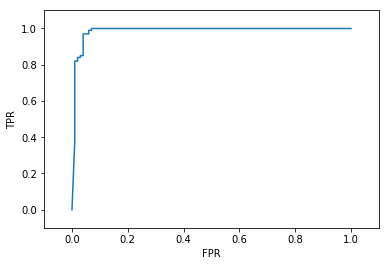

In [14]:
Mean_show=np.reshape(faces_mean,(10,10))
cv2.imwrite('Mean_FA_face.jpg',Mean_show)

Mean_show_non=np.reshape(non_faces_mean,(10,10))
cv2.imwrite('Mean_FA_non.jpg',Mean_show_non)

cv2.imwrite('Cov_FA_face.jpg',Cov)

cv2.imwrite('Cov_FA_non.jpg',Cov_non)



posterior_classified_face = positive_likelihood_for_positive_test/(positive_likelihood_for_positive_test + negative_likelihood_for_positive_test)
posterior_classified_non_face = negative_likelihood_for_positive_test/(negative_likelihood_for_positive_test + positive_likelihood_for_positive_test)
posterior_misclassified_non_face = positive_likelihood_for_negative_test/(positive_likelihood_for_negative_test + negative_likelihood_for_negative_test)
posterior_misclassified_face = negative_likelihood_for_negative_test/(negative_likelihood_for_negative_test + positive_likelihood_for_negative_test)

count = 0
for i in range(len(posterior_classified_face)):
    if posterior_classified_face[i] > posterior_classified_non_face[i]:
        count=count+1
print("correctly classified faces: ", count)
count1 = 0
for i in range(len(posterior_classified_face)):
    if posterior_misclassified_face[i] > posterior_misclassified_non_face[i]:
        count1=count1+1
print("correctly classified non-faces: ", count1) 
count_false_positive = 0
for i in range(len(posterior_classified_face)):
    if posterior_misclassified_non_face[i]> 0.5:
        count_false_positive=count_false_positive+1
print("False Positive Rate ", count_false_positive/100)
count_false_negative = 0
for i in range(len(posterior_classified_face)):
    if posterior_classified_non_face[i] > 0.5:
        count_false_negative = count_false_negative + 1
print("False Negative Rate ", count_false_negative/100) 
misclassification = (float(count_false_positive + count_false_negative)) / (len(posterior_classified_face) + len(posterior_classified_face))
print("Misclassification Rate", misclassification) 


posterior_classification = np.append(posterior_classified_face, (posterior_misclassified_non_face))
labels = np.append(np.ones(100), np.zeros(100))

fpr, tpr, _ = roc_curve(labels, posterior_classification, pos_label=1)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR" )
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.show()

### Grading part

In [10]:
### MY CODE HERE